**Web Analytics Basics** <br />
Prof. Dr. Jan Kirenz

In [39]:
import re 
import requests 
from bs4 import BeautifulSoup
import pprint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 16
import seaborn as sns
from IPython.display import IFrame

In [40]:
#IFrame('https://n26.com', width=800, height=450)

## Introduction

This notebook is obtained from [Koehrsen, W. (2018)](https://towardsdatascience.com/web-scraping-regular-expressions-and-data-visualization-doing-it-all-in-python-37a1aade7924) and demonstrates how to scrape webdata using the modules **Beautiful Soup 4** and **Requests**. Furthermore, it covers data tidying using the module **Regular Expressions** as well as data visualizing with **Matplotlib** und **Seaborne**. 

First of all, take a look at this [website](https://www.cleveland.com/metro/index.ssf/2017/12/case_western_reserve_university_president_barbara_snyders_base_salary_and_bonus_pay_tops_among_private_colleges_in_ohio.html)

In [41]:
# Display website in Notebook
IFrame('https://www.cleveland.com/metro/index.ssf/2017/12/case_western_reserve_university_president_barbara_snyders_base_salary_and_bonus_pay_tops_among_private_colleges_in_ohio.html', width=800, height=450)

from which we like to obain an unordered list of total compensations for several presidents at private colleges in Ohio in 2015 (starting with Grant Cornwell). 

Afterwards, we use the extracted information to calculate how much the respective president earn in 5 minutes of their time and visualize the results.

---

Source: 

## Web Scraping Using Requests and Beautiful Soup (bs4)

We use the requests library for retrieving content from the webpage, and bs4 (BeautifulSoup) for extracting the relevant information. 

First, we make a `get` request to a website. Then, we create a Beautiful Soup object from the content that is returned and parse it using several methods.

In [42]:
# Make the GET request to a url
r = requests.get('http://www.cleveland.com/metro/index.ssf/2017/12/case_western_reserve_university_president_barbara_snyders_base_salary_and_bonus_pay_tops_among_private_colleges_in_ohio.html')
# Extract the content
c = r.content
# Create a soup object
soup = BeautifulSoup(c)
#pprint.pprint(soup)

Our data is in there somewhere, but we need to extract it. To select our data from the soup, we need to find the right [CSS selectors](https://www.w3schools.com/cssref/css_selectors.asp). 

One way to do this is by going to the webpage and inspecting the element. In this case, we can also just look at the soup (we use the module [pretty-print](https://docs.python.org/3/library/pprint.html) to print the output) and see that our desired data resides under a `<div>` HTML tag with the attribute `class = "entry-content"`. Using this info and the `.find` method of our soup object, we can pull out the main article content.

In [43]:
# Find the element on the webpage
main_content = soup.find('div', attrs = {'class': 'entry-content'})
pprint.pprint(main_content)

<div class="entry-content"><p class="article__paragraph article__paragraph--left" id="UDT3SSNMTRCTFDQE6DBFNJODLI">CLEVELAND, Ohio - <a href="http://www.case.edu/">Case Western Reserve University </a>President Barbara Snyder's $700,312 base pay and $175,000 bonus in 2015 again made her the highest paid private college leader in Ohio, according to an annual report.</p><div id="inarticle-1"></div><p class="article__paragraph article__paragraph--left" id="AOJSWF2SO5F6NLAFYE77J7FAPI">Nationally, Snyder's total compensation of $1.154 million, which can include deferred compensation and other pay, ranked 41st out of 541 presidents of private colleges according to the report by the <a href="http://chronicle.com/">Chronicle of Higher Education.</a></p><div class="InContent_Center_Background"><div class="InContent_Center_Padding"><div class="ad-observer" id="InContent_Center_AOJSWF2SO5F6NLAFYE77J7FAPI"></div></div></div><div id="inarticle-2"></div><p class="article__paragraph article__paragraph-

This returns another soup object which is not quite specific enough. To select the unordered list, we need to find the `<ul>` tag (see above in the main_content object). 

We also want to deal with only the text in the table, so we use the `.text` attribute of the soup and print the result with pretty-print.

In [44]:
# Extract the relevant information as text
content = main_content.find('ul').text
pprint.pprint(content)

('Grant Cornwell, College of Wooster (left in 2015): $911,651Marvin Krislov, '
 'Oberlin College (left in 2016): \xa0$829,913Mark Roosevelt, Antioch College, '
 '(left in 2015): $507,672Laurie Joyner, Wittenberg University (left in 2015): '
 '$463,504Richard Giese, University of Mount Union (left in 2015): '
 '$453,800Sean Decatur,Kenyon College: $451,698Adam Weinberg, Denison '
 'University: $435,322Daniel Dibiasio, Ohio Northern University: $414,716Denvy '
 'Bowman, Capital University (left in 2016): $388,570Anne Steele, Muskingum '
 'University (left in 2016): $384,233Kathy Krendl, Otterbein University: \xa0'
 '$378,035Rockwell Jones, Ohio Wesleyan University: $366,625Robert Helmer, '
 'Baldwin Wallace University: $365,616Robert Huntington, Heidelberg '
 'University: $300,005Lori Varlotta, Hiram College: $293,336Joseph Bruno, '
 'Marietta College (left in 2016): $288,295W. Richard Merriman Jr., University '
 'of Mount Union (started in June 2015): $221,761')


We now have the data we need to focus on as a text string. 

The next step is to parse this information using **regular expressions** to identify the presidents, colleges, and salaries. 

The get an overview about tis topic, read the Python documentation for the [re module](https://docs.python.org/3/library/re.html).

## Regular Expressions Using re

The basic idea of regular expressions is we define a pattern (the “regular expression” or “regex”) that we want to match in a text string and then search in the string to return matches. The Python re module provides regular expression matching operations similar to those found in Perl.

Some of these patterns contain both the content we want to match and special characters that change how the pattern is interpreted. 

In our cae, there are 3 pieces of information we need to extract from the text:

- The names of the presidents
- The names of the colleges
- The salaries

### Presidents

First we want to extract the names of the presidents. We do this taking advantage of the fact that the names come at the beginning of each newline. 

We therefore use an expression in the multiline mode, `re.M`, which treats every newline character as the end of the string (so the next character is the start of a string). Regular expression matching operations: 


- `r`: Prefixing with an r indicates to the string that backslashes \ should be treated literally and not as escape characters for python. Detailed Explanation: Regular expressions use the backslash character ('\') to indicate special forms or to allow special characters to be used without invoking their special meaning. This collides with Python’s usage of the same character for the same purpose in string literals; for example, to match a literal backslash, one might have to write '\\\\' as the pattern string, because the regular expression must be \\, and each backslash must be expressed as \\ inside a regular Python string literal. The solution is to use Python’s raw string notation for regular expression patterns; backslashes are not handled in any special way in a string literal prefixed with 'r'. So r"\n" is a two-character string containing '\' and 'n', while "\n" is a one-character string containing a newline. Usually patterns will be expressed in Python code using this raw string notation. See [re documentation](https://docs.python.org/3/library/re.html).


- `re.M`: re.MULTILINE. When specified, the pattern character `^` matches at the beginning of the string and at the beginning of each line (immediately following each newline); and the pattern character `$` matches at the end of the string and at the end of each line (immediately preceding each newline). By default, `^` matches only at the beginning of the string, and `$` only at the end of the string and immediately before the newline (if any) at the end of the string. Corresponds to the inline flag (?m).


- `^` (Caret.): Matches the start of the string, and in MULTILINE mode also matches immediately after each newline


- `[]`: Used to indicate a set of characters. In a set: [A-Z] will match any upercase ASCII letter


- `{m}`: Specifies that exactly m copies of the previous RE should be matched; fewer matches cause the entire RE not to match. For example, a{6} will match exactly six 'a' characters, but not five.


- `.`: (Dot.) In the default mode, this matches any character except a newline. If the DOTALL flag has been specified, this matches any character including a newline.


- `+` Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.


- `?`: Causes the resulting RE to match 0 or 1 repetitions of the preceding RE. ab? will match either ‘a’ or ‘ab’.


The names also all end with a comma, so we can use this to bound the names.


- `(?:...)`: A non-capturing version of regular parentheses. Matches whatever regular expression is inside the parentheses, but the substring matched by the group cannot be retrieved after performing a match or referenced later in the pattern. 

In [45]:
# Create a pattern to match names
name_pattern = re.compile(r'^([A-Z]{1}.+?)(?:,)', flags = re.M)
# Find all occurrences of the pattern
names = name_pattern.findall(content)
names

['Grant Cornwell']

### Colleges

The next piece of information to extract is the name of the schools. We can use the fact that each school name is preceded either by a comma (Kenyon College) or a comma and a space. 

Each school name ends with a colon : or with a space and a left parenthesis ( or with a comma ,. 

We use both of these to bound the college expression and extract the useful information.

In [46]:
# Remind ourselves what our soup looks like
pprint.pprint(content)

('Grant Cornwell, College of Wooster (left in 2015): $911,651Marvin Krislov, '
 'Oberlin College (left in 2016): \xa0$829,913Mark Roosevelt, Antioch College, '
 '(left in 2015): $507,672Laurie Joyner, Wittenberg University (left in 2015): '
 '$463,504Richard Giese, University of Mount Union (left in 2015): '
 '$453,800Sean Decatur,Kenyon College: $451,698Adam Weinberg, Denison '
 'University: $435,322Daniel Dibiasio, Ohio Northern University: $414,716Denvy '
 'Bowman, Capital University (left in 2016): $388,570Anne Steele, Muskingum '
 'University (left in 2016): $384,233Kathy Krendl, Otterbein University: \xa0'
 '$378,035Rockwell Jones, Ohio Wesleyan University: $366,625Robert Helmer, '
 'Baldwin Wallace University: $365,616Robert Huntington, Heidelberg '
 'University: $300,005Lori Varlotta, Hiram College: $293,336Joseph Bruno, '
 'Marietta College (left in 2016): $288,295W. Richard Merriman Jr., University '
 'of Mount Union (started in June 2015): $221,761')


Regular expression:

- `|`: A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B. An arbitrary number of REs can be separated by the '|' in this way. 


- `\s`: is a common shorthand for "any whitespace character". This includes spaces, tabs, and newlines.


- `*?`: The * quantifier means "match this token zero or more times". The ?, when applied to a quantifier, makes it lazy - it will match as little as it can, going from left to right one character at a time.

In [47]:
# Make school patttern and extract schools
school_pattern = re.compile(r'(?:,|,\s)([A-Z]{1}.*?)(?:\s\(|:|,)')
schools = school_pattern.findall(content)
schools

['College of Wooster',
 'Oberlin College',
 'Antioch College',
 'Wittenberg University',
 'University of Mount Union',
 'Kenyon College',
 'Denison University',
 'Ohio Northern University',
 'Capital University',
 'Muskingum University',
 'Otterbein University',
 'Ohio Wesleyan University',
 'Baldwin Wallace University',
 'Heidelberg University',
 'Hiram College',
 'Marietta College',
 'University of Mount Union']

### Salaries

Finally, we need to get the salaries. This is relatively easy because all of the salaries are preceded by a dollar sign. Once we have extract the salaries as strings, we can use a Python list comprehension to remove the $ , and convert the string to a float. 

#### Pattern to extract salaries

In [48]:
# Pattern to match the salaries
salary_pattern = re.compile(r'\$.+')
salaries = salary_pattern.findall(content)
salaries

['$911,651Marvin Krislov, Oberlin College (left in 2016): \xa0$829,913Mark Roosevelt, Antioch College, (left in 2015): $507,672Laurie Joyner, Wittenberg University (left in 2015): $463,504Richard Giese, University of Mount Union (left in 2015): $453,800Sean Decatur,Kenyon College: $451,698Adam Weinberg, Denison University: $435,322Daniel Dibiasio, Ohio Northern University: $414,716Denvy Bowman, Capital University (left in 2016): $388,570Anne Steele, Muskingum University (left in 2016): $384,233Kathy Krendl, Otterbein University: \xa0$378,035Rockwell Jones, Ohio Wesleyan University: $366,625Robert Helmer, Baldwin Wallace University: $365,616Robert Huntington, Heidelberg University: $300,005Lori Varlotta, Hiram College: $293,336Joseph Bruno, Marietta College (left in 2016): $288,295W. Richard Merriman Jr., University of Mount Union (started in June 2015): $221,761']

#### Converting dollar strings to numbers

First we review a brief example of the steps necessary to tidy our data. 

First, we use the split method to split each string into two separate strings at the comma (starting with the first character after the $). Then, we join the two strings together with no separating character and convert the result to a float. All of this is wrapped in a list comprehension. The end result is a list of numeric values representing the Presidents' salaries. As a second option, we cover the `re.sub`method

Examples to illustrate data conversion:

**Simple data example with two options for data tidying**



In [49]:
# Example of untidy salary
salary = '$876,001'

We have multiple options to make the data tidy and cover only two of them here: 

- Option 1: Split and join
- Option 2: re.sub

---

**Option 1:**

In [50]:
# Option 1: Using split and join (see below for explanation)
float(''.join(salary[1:].split(',')))

876001.0

Detailed explanation of option 1:

In [51]:
# Step 1: Exclude the $ and split the string on the comma
salary[1:].split(',')

['876', '001']

In [52]:
# Step 2: Same operation but now join the list with no space
''.join(salary[1:].split(','))

'876001'

In [53]:
# Step 3: Finally convert the string to a float
float(''.join(salary[1:].split(',')))

876001.0

---

**Option 2** uses re.sub:

- `re.sub(pattern, repl, string, count=0, flags=0)`: 
Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl. If the pattern isn’t found, string is returned unchanged. repl can be a string or a function; if it is a string, any backslash escapes in it are processed. That is, \n is converted to a single newline character, \r is converted to a carriage return, and so forth. Unknown escapes such as \& are left alone.

In [54]:
float(re.sub("\D", "", salary))

876001.0

---

**Example list to test options**

In [55]:
# Messy salaries
salaries = ['$876,001', '$543,903', '$2453,896']
salaries

['$876,001', '$543,903', '$2453,896']

In [56]:
# Option 1: Convert salaries to numbers in a list comprehension 
[int(''.join(s[1:].split(','))) for s in salaries]

[876001, 543903, 2453896]

In [57]:
# Option 2: re.sub
[int(re.sub("\D", "", s)) for s in salaries]

[876001, 543903, 2453896]

---
---

**Use methods on our data:**

In [58]:
# Extract all the salaries and convert to integers
salaries = salary_pattern.findall(content)

# List comprehension to convert strings to floats
salaries = [int(''.join(s[1:].split(','))) for s in salaries]

ValueError: invalid literal for int() with base 10: '911651Marvin Krislov Oberlin College (left in 2016): \xa0$829913Mark Roosevelt Antioch College (left in 2015): $507672Laurie Joyner Wittenberg University (left in 2015): $463504Richard Giese Universi

In [ ]:
salaries

[911651,
 829913,
 507672,
 463504,
 453800,
 451698,
 435322,
 414716,
 388570,
 384233,
 378035,
 366625,
 365616,
 300005,
 293336,
 288295,
 221761]

In [ ]:
# check if lenght is correct
len(names) == len(schools) == len(salaries)

True

## Visualization

We will use the matplotlib and seaborn libraries for visualizing the results. We'll start off by storing the data in a Pandas DataFrame.

In [ ]:
# Put information into a dataframe
df = pd.DataFrame({'salary': salaries, 
                   'President': names,
                   'College': schools})

# Sort the values by highest to lowest salary
df = df.sort_values('salary', ascending=False).reset_index().drop(columns='index')

In [ ]:
df

,salary,President,College
0,911651,Grant Cornwell,College of Wooster
1,829913,Marvin Krislov,Oberlin College
2,507672,Mark Roosevelt,Antioch College
3,463504,Laurie Joyner,Wittenberg University
4,453800,Richard Giese,University of Mount Union
5,451698,Sean Decatur,Kenyon College
6,435322,Adam Weinberg,Denison University
7,414716,Daniel Dibiasio,Ohio Northern University
8,388570,Denvy Bowman,Capital University
9,384233,Anne Steele,Muskingum University


### Quick First Visualization

We can use plotting functionality built into pandas to create an initial figure.

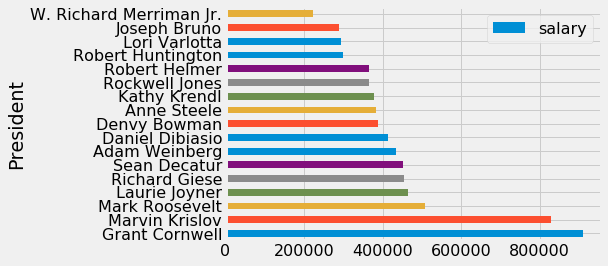

In [ ]:
# Make a horizontal bar chart
df.plot(kind='barh', x = 'President', y = 'salary');

### Improved plot

We now iterativelly improve the graphic. 

In [ ]:
# Sort the values by highest to lowest salary
df = df.sort_values('salary', ascending=False).reset_index()

# Shorten this one name for plotting
df.loc[df['College'] == 'University of Mount Union', 'College'] = 'Mount Union'

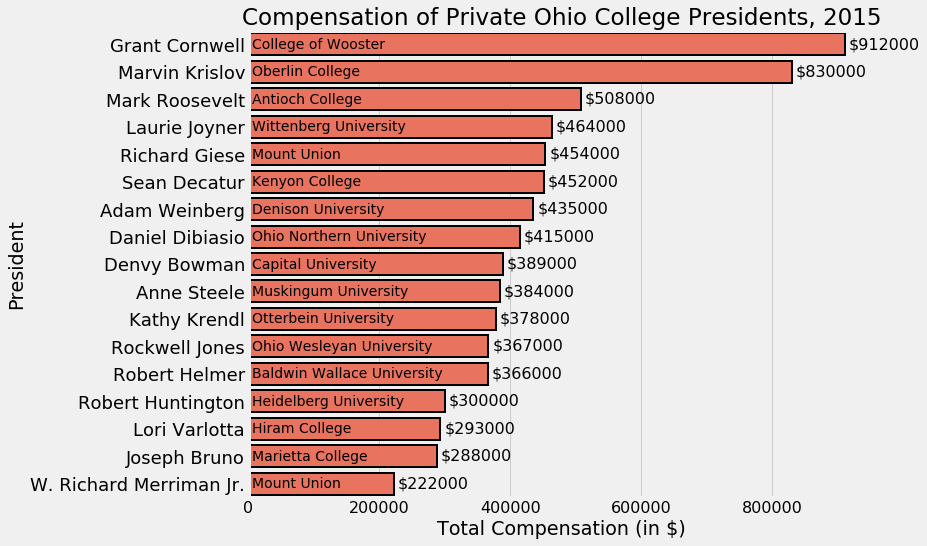

In [ ]:
# Create the basic figure
plt.figure(figsize=(10, 8))

sns.barplot(x = 'salary', 
            y = 'President', 
            data = df, 
            color = 'tomato', 
            edgecolor = 'k', 
            linewidth = 2)

# Add text showing values and colleges
for i, row in df.iterrows():
    plt.text(x = row['salary'] + 6000, y = i + 0.15, s = '$%d' % (round(row['salary'] / 1000) * 1000))
    plt.text(x = 5000, y = i + 0.15, s = row['College'], size = 14)

# Labels
plt.xticks(size = 16); plt.yticks(size = 18)
plt.xlabel('Total Compensation (in $)')
plt.ylabel('President') 
plt.title('Compensation of Private Ohio College Presidents, 2015');

In [ ]:
# Calculate earnings for 5 minutes 
five_minutes_fraction = 5 / (2000 * 60)
total_df = pd.DataFrame(df.groupby('College')['salary'].sum())
total_df['five_minutes_earnings'] = round(total_df['salary'] * five_minutes_fraction)
total_df = total_df.sort_values('five_minutes_earnings', ascending = False).reset_index()

total_df

,College,salary,five_minutes_earnings
0,College of Wooster,911651,38.0
1,Oberlin College,829913,35.0
2,Mount Union,675561,28.0
3,Antioch College,507672,21.0
4,Kenyon College,451698,19.0
5,Wittenberg University,463504,19.0
6,Denison University,435322,18.0
7,Ohio Northern University,414716,17.0
8,Capital University,388570,16.0
9,Muskingum University,384233,16.0


### Final plot

After several attempts (I have not shown all my failures along the way), we can create the final plot: how much are you paying for five minutes of your president's time. I wouldn't say the plot is production quality, but it is a good ending point for this project!

In [ ]:
# Text for caption
txt = 'Calculated from 2015 Total Compensation assuming 2000 hrs worked/year. Source: Chronical of Higher Education'

# Create the basic barplot
plt.figure(figsize=(10, 8))
sns.barplot(x = 'five_minutes_earnings', 
            y = 'College', 
            data = total_df, 
            color = 'blue', 
            edgecolor = 'k', 
            linewidth = 2)

# Add the text with the value
for i, row in total_df.iterrows():
    plt.text(x = row['five_minutes_earnings'] + 0.5, 
             y = i + 0.15, 
             s = '$%d' % (row['five_minutes_earnings']), 
             size = 18)

# Add the caption
plt.text(x = -5, 
         y = 20, 
         s = txt, 
         size = 14)

# Add the labels
plt.xticks(size = 16); plt.yticks(size = 18)
plt.xlabel('Value ($)')
plt.ylabel('') 
plt.title("Value of Five Minutes of a President's Time");

NameError: name 'total_df' is not defined

<Figure size 720x576 with 0 Axes>